## **Análisis de Sistemas Térmicos usando Python**

Clase 5:    Uso de biblioteca fluids para evaluar pérdida de carga en tuberías

            Uso de unidades en Python

Primero instalamos en Colab las librerías necesarias para el desarrollo del ejemplo

In [1]:
#pip install Coolprop

In [2]:
#pip install fluids

En este ejemplo buscamos analizar el sistema de tuberías que se muestra en la figura. 

El sistema transporta agua, a 20°C, en una tubería de 38 mts de longitud en la horizontal y una diferencia de altura de 8 mts.

Buscamos evaluar el efecto del diámetro de la tubería en la potencia requerida por el sistema de bombas, con tal de asegurar un caudal de 20 litros por minuto.

<img src="Fig Class_7.png" alt="Example" />

Importamos las librerías que iremos a utilizar, destacando fluids y su opción de manejo de unidades.
Asimismo, aprovechamos de importar el valor de la aceleración de gravedad desde la librería SciPy

In [3]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np

from fluids.units import *
from scipy.constants import g

Definimos las variables asociadas a los datos de entrada del problema, y aprovechamos de usar la extensiónd e unidades de fluids.

Cabe mencionar que esta extensión está basada en el paquete [pint](https://pint.readthedocs.io/en/stable/).

In [4]:
g = g * u.m/u.s**2
z = 8 * u.m
L = 38 * u.m + z

V_dot = (20 * u.liter/u.minute).to(u.m**3/u.s)

Propiedades termofísicas del fluido - Agua,

en este caso usamos CoolProp - (**Cuidado:** *Coolprop no permite trabajar con unidades, solo con valores adimensionales*)

In [5]:
fluid = 'water'
P_o = 101325
T_o = 20 + 273.15
rho = cp.PropsSI("D", "T", T_o, "P", P_o, fluid)*u.kg/u.m**3
mu = cp.PropsSI("V","T", T_o, "P", P_o, fluid)*u.Pa*u.s

Para suministrar el caudal de agua deseado la bomba debe suministrar suficiente presión para superar (1) la diferencia de altitud y (2) los efectos de fricción en la red de tuberías de la red,

$\Delta P_{\text {pump}}=\Delta P_{\text{elevation}}+\Delta P_{\text{friction}}$


El requerimiento de presión necesario para superar la diferencia de altitud es

$ \Delta P_{\text{elevation}}= \rho g z $



In [6]:
DELTA_P_e = (rho * g * z).to('kPa')
DELTA_P_e

78.31254521709047 <Unit('kilopascal')>

La pérdida de carga debido a la fricción puede calcularse realizando un análisis de la fricción de la tubería,

$\Delta P_{\text{friction}} =f \frac{L}{D} \frac{\rho V^{2}}{2}$

La velocidad en la tubería es una función del caudal y del diámetro de la tubería,

$V=\frac{\dot{V}}{A}=\frac{4 \dot{V}}{\pi D^{2}}$

Sustituyendo esta expresión en la ecuación de la caída de presión por fricción se obtiene

$\Delta P_{\text {friction }}=f \frac{8 \rho L \dot{V}^{2}}{\pi^{2} D^{5}}$

De esta forma, arbitraremos un valor del diámetro de la tubería para determinamos la velocidad

In [7]:
D = 0.02 * u.m
A_D = (np.pi * D**2)/4
V = V_dot / A_D

Luego determinamos el número de Reynolds y posterimente el factor de fricción, a través de la librería **fluids**

In [8]:
Re = (fld.Reynolds(D, rho, V, mu)).to('dimensionless')
Re

21148.857027566508 <Unit('dimensionless')>

Como el factor de fricción es función de la rugosidad deñl material, recurrimos al diccionaroio de materiales de la librería **fluids**.

In [9]:
epsilon = (fld.friction.material_roughness('plastic water pipe')* u.mm).to(u.m)
epsilon

1.4e-06 <Unit('meter')>

Finalmente se determina el factor de friccion utilizando la misma librería, especificando la correlación que deseamos usar. En general las correlaciones varían poco. En este caso se usa la de Colebrook-White.

In [10]:
f = fld.friction.friction_factor(Re, eD=epsilon/D, Method='Colebrook')
f

0.025689752029283967 <Unit('dimensionless')>

Pero si usaramos la correlación de Churchill, vemos que la variación es muy pequeña

In [11]:
f_c = fld.friction.friction_factor(Re, eD=epsilon/D, Method='Churchill_1977') 
f_c

0.02565724726615475 <Unit('dimensionless')>

Finalmente determinamos el requerimiento de presión para vencer las pérdidas de fricción en la tubería.

In [12]:
D

0.02 <Unit('meter')>

In [13]:
DELTA_P_f = ((f * 8 * rho * L * V_dot**2)/(np.pi**2 * D**5)).to(u.kPa)
DELTA_P_f

33.199854034824035 <Unit('kilopascal')>

La pérdida de carga por singularidades sería asociada a los 2 codos de 90 grados.

La expresión de la presion necesasaria para vencer la pérdida de carga por singularidades es:

$\Delta P_{singular} = \sum_{i}{K_i \rho \frac{V_1^2}{2}}$

Luego, Utilizando nuevamente el diccionario de la librería **fluids**, tenemos:


In [14]:
K = fld.fittings.bend_rounded_Crane(Di=D.magnitude, bend_diameters=2, angle=90) # bend_diameters = Number of diameters of pipe making up the bend radius

DELTA_P_s = (2 * (K * rho * 8* V_dot**2)/(np.pi**2 * D**4)).to(u.kPa)
DELTA_P_s 

0.3201975732375594 <Unit('kilopascal')>

Finalmente, el requerimiento de presión es la suma de los 3 efectos antes calculados

In [15]:
Delta_P = DELTA_P_f + DELTA_P_e + DELTA_P_s
Delta_P

111.83259682515207 <Unit('kilopascal')>

**Análisis de Sensibilidad**

Ahora, buscamos analizar el efecto del diámetro de la tuberíam en el requerimiento de presión antes calculado para un diámetro arbitrario.

PAra esto, utilizaremos la opción de vectores de la bibloteca **fluids**, que nos permite calcular el requerimiento de presión para un arreglo de diámetros.

Esta opción consiudera los arreglos como arreglos de Numpy

Les recomiendo también revisar la opción de **numba_vectorized**

In [16]:
from fluids.vectorized import * 

Definimos un arreglo de diámetros de tuberías usando la función linspace de numpy. Esta función genera un arreglo de números equiespaciados entre dos valores. En este caso, generamos un arreglo de 150 números entre 5 mm y 15 cm.

Para cada valor de dicho arreglo calculamos el área de la tubería, velocidad, número de Reynolds y rugosidad relativa.

In [17]:
D_range = np.linspace(0.005, 0.15, 150)*u.m

A_range = (np.pi * D_range**2)/4
V_range = V_dot / A_range
Re_range = Reynolds(D_range, rho, V_range, mu)

eD_range = epsilon/D_range

c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\numpy\lib\function_base.py:2336: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  args = [asarray(arg) for arg in args]
c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\numpy\lib\function_base.py:2385: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  inputs = [asanyarray(a, dtype=object) for a in args]


Finalmente, tederminamos el factor de fricción asociado a cada tubería definida por el arreglo de diámetros

In [18]:
f_range = friction_factor(Re=Re_range, eD=eD_range) 

f_range

array([0.01990804, 0.02033839, 0.02078607, 0.02123175, 0.02166701,
       0.02208843, 0.0224949 , 0.02288643, 0.02326356, 0.02362708,
       0.02397784, 0.02431668, 0.02464444, 0.02496187, 0.0252697 ,
       0.02556856, 0.02585906, 0.02614174, 0.02641709, 0.02668557,
       0.02694758, 0.0272035 , 0.02745368, 0.02769844, 0.02793806,
       0.02817281, 0.02840295, 0.02862869, 0.02885025, 0.02906783,
       0.0292816 , 0.02949174, 0.02969841, 0.02990175, 0.0301019 ,
       0.03029899, 0.03049315, 0.03068448, 0.03087309, 0.03105909,
       0.03124256, 0.03142361, 0.03160231, 0.03177874, 0.03195298,
       0.0321251 , 0.03229517, 0.03246326, 0.03262943, 0.03279373,
       0.03295622, 0.03311695, 0.03327599, 0.03343336, 0.03358913,
       0.03374333, 0.03389601, 0.03404721, 0.03419696, 0.03434531,
       0.03449229, 0.03463793, 0.03478227, 0.03492534, 0.03506717,
       0.03520779, 0.03534723, 0.03548551, 0.03562267, 0.03575872,
       0.03589369, 0.0360276 , 0.03616049, 0.03629236, 0.03642

Ahora, determinamos los requerimientos de presión para vencer las pérdidas por fricción en la tubería.

In [19]:
DELTA_P_f_range = ((f_range * 8 * rho * (L + z) * V_dot**2)/(np.pi**2 * D_range**5)).to(u.kPa)
DELTA_P_f_range

Magnitude,[30927.198653661446 12985.539513006037 6239.707045653529 3308.790210806129 1891.5298547129823 1147.2860590079918 729.9865726048988 483.17910189513486 330.5939091907522 232.6667440157457 167.7764114185262 123.57156527328415 92.7215047605537 70.72809272207823 54.7493066213115 42.94232642540491 34.08426234312401 27.34656990155223 22.15725230446586 18.114641060620922 14.932261869560415 12.402872744450615 10.374578515460094 8.734700208911118 7.398713282128603 6.302553645377149 5.39719537368908 4.644782418348468 4.0158373476226465 3.4872256994388025 3.0406565282067697 2.6615675318205247 2.338288798084922 2.061410320419249 1.8232998741941002 1.6177327808592348 1.439605596205842 1.2847132242640242 1.149574309144778 1.0312936253330622 0.9274530061008842 0.8360244202377036 0.7553003391999933 0.683837678141754 0.6204124503699462 0.5639829209890878 0.5136595362911438 0.4686802803788994 0.4283903985426919 0.3922256493750422 0.35969842031924304 0.3303861760993862 0.3039218151157987 0.279985592082644 0.2582983309917214 0.23861570476334829 0.22072339964429527 0.20443301580623163 0.18957858244273412 0.17601358732274797 0.16360843829732055 0.15224828850758487 0.1418311686604153 0.13226637924095577 0.12347310332796292 0.11537920709438473 0.10792020037169982 0.10103833404043969 0.09468181464817589 0.08880411968486898 0.08336339947276013 0.07832195374231854 0.07364577273897345 0.06930413419609019 0.06526924876581477 0.061515947560349046 0.0580214063542466 0.054764901760108606 0.05172759533762627 0.04889234214753066 0.04624352073282491 0.043766881912305364 0.04144941411636614 0.039279223291217816 0.0372454256523239 0.03533805178725424 0.03354796079749265 0.03186676333240701 0.030286752510309514 0.02880084184444378 0.0274025093985 0.026085747489144197 0.024845017333976083 0.023675208113950467 0.022571599981006545 0.02152983059565341 0.020545864826581783 0.019615967285899538 0.01873667741007482 0.0179047868287742 0.017117318792062967 0.016371509451379204 0.01566479081172337 0.014994775191982113 0.01435924104754917 0.013756120024686807 0.013183485129631443 0.01263953990749008 0.012122608536685451 0.011631126754240774 0.011163633535691758 0.01071876346099249 0.010295239704549502 0.009891867593568037 0.009507528684307272 0.009141175310689016 0.008791825564049944 0.008458558666727262 0.008140510705669396 0.00783687069541181 0.007546876942590339 0.00726981368671516 0.007005007994227433 0.00675182688493423 0.006509674671789695 0.006277990496681512 0.006056246046411769 0.005843943434445086 0.005640613235250927 0.005445812659202812 0.005259123857028358 0.005080152343739184 0.004908525532819828 0.004743891372227323 0.004585917074455963 0.004434287933561481 0.00428870622262178 0.004148890165642613 0.0040145729784013305 0.0038855019731641282 0.0037614377226163113 0.0036421532787145367 0.0035274334425075093 0.0034170740812810283 0.003310881489666015 0.0032086717916077205 0.0031102703803319036 0.003015511393662002 0.0029242372222414085 0.0028362980483989234]
Units,kilopascal


Similarmente con las pérdidas asociadas a las singularidades

In [24]:
K_range = bend_rounded_Crane(Di=D_range, bend_diameters=2, angle=90) # bend_diameters = Number of diameters of pipe making up the bend radius
DELTA_P_s_range = (2 * (K_range * rho * 8* V_dot**2)/(np.pi**2 * D_range**4)).to(u.kPa)
DELTA_P_s_range

c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\numpy\lib\function_base.py:2336: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  args = [asarray(arg) for arg in args]
c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\numpy\lib\function_base.py:2385: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  inputs = [asanyarray(a, dtype=object) for a in args]


Magnitude,[122.98661931299841 57.045327670304395 29.75704311525455 16.9222699261137 10.281518665751802 6.582183958975735 4.396349940031783 3.0411181572140937 2.1665473688385397 1.582732974792235 1.1815492689567433 0.8988561878694561 0.6952350609383966 0.5457006933609279 0.4339802302520731 0.3492166300757123 0.2840086013806845 0.2332121052045312 0.19318889715898244 0.16132457364949176 0.13571305485476134 0.1149461275898914 0.09797064247942813 0.08399008198403335 0.07239572253299924 0.06271784385728488 0.05459071494003497 0.04772717453090457 0.04189997718709164 0.0369279655883556 0.032665723271334456 0.02899576287918244 0.025822579281690287 0.02306808669265409 0.020668091652305688 0.01856954754475331 0.0167284032481099 0.015107906705112206 0.013677259201335142 0.012410541766253901 0.011285854025088598 0.01028461988990452 0.009391025005581262 0.00859155880106129 0.007874640015582617 0.00723030916386129 0.006649974931391777 0.006126204214244425 0.005652547631554981 0.005223393988172307 0.004833848458135117 0.004479630278492475 0.0041569865493527175 0.003862619377066861 0.0035936241091940003 0.0033474368201032428 0.0031217895361816497 0.0029146719562902733 0.0027242986393247793 0.002549080806663401 0.002387602050921656 0.0022385973600960014 0.0021009349628742344 0.001973600580602279 0.00185568373730627 0.0017463658338247416 0.0016449097375579448 0.0015506506772437901 0.0014629882638606793 0.0013813794853235347 0.001305332544965137 0.001234401432603292 0.0011681811328770981 0.0011063033889788638 0.0010484329513122026 0.0009942642503021973 0.0009435184408437213 0.0008959407729261563 0.0008512982490057267 0.0008093775338678696 0.0007699830871632677 0.000732935492622336 0.0006980699612469916 0.000665234988622872 0.0006342911489558287 0.0006051100105685728 0.0005775731594440217 0.0005515713190107065 0.0005270035557665442 0.0005037765615590237 0.00048180400440694465 0.000461005940682288 0.00044130828228846963 0.0004226423131885145 0.0004049442502668186 0.0003881548440624488 0.0003722190154001583 0.00035708552437591675 0.000342706668534026 0.000329038007409136 0.0003160381109041715 0.000303668329239013 0.0002918925824389492 0.0002806771675399261 0.0002699905818726642 0.0002598033609524656 0.0002500879296484104 0.00024081846543669823 0.00023197077265997465 0.00022352216681918144 0.00021545136801818013 0.00020773840276538675 0.00020036451341196127 0.00019331207457372733 0.00018656451594474937 0.0001801062509651624 0.00017392261085504202 0.0001679997835704506 0.00016232475727777352 0.00015688526797856195 0.000151669750949703 0.00014666729569322415 0.00014186760411672252 0.00013726095168957106 0.00013283815134196146 0.00012859051989370509 0.000124509846817757 0.00012058836515980782 0.00011681872445019008 0.00011319396545789698 0.00010970749664885655 0.00010635307222184555 0.00010312477160568407 0.00010001698031070316 9.702437203602484e-05 9.414189194199318e-05 9.136474100423439e-05 8.868836137234869e-05 8.61084226622167e-05 8.362080911637346e-05 8.122160757192349e-05 7.890709618007253e-05 7.66737338255736e-05 7.451815019826644e-05 7.243713647244982e-05 7.042763655310631e-05 6.848673885100881e-05 6.66116685515169e-05 6.479978034442165e-05 6.304855158455486e-05]
Units,kilopascal


Y determinamos los requerimientos totales

In [22]:
Delta_P_range = DELTA_P_f_range + DELTA_P_e + DELTA_P_s_range
Delta_P_range

Magnitude,[31128.497818191536 13120.897385893431 6347.7766339858745 3404.025025949333 1980.1239185958245 1232.180788184058 812.695467762021 564.5327652694394 411.0730017766812 312.56202220762844 247.2705059045734 202.78296667824407 171.72928503858256 149.58633863252965 133.49583206865404 121.60408827257109 112.68081616159517 105.89232722384723 100.6629864187153 96.5885108513609 93.38052014150566 90.83036408913098 88.78509437502998 87.13123550798562 85.78365422175207 84.6778167063249 83.76433130571958 83.00505480996985 82.37028254190021 81.83669888211763 81.38586746856858 81.00310851179017 80.67665659445709 80.39702362420238 80.15651318293689 79.94884754549446 79.76887921654442 79.61236634805961 79.47579678543659 79.3562493841898 79.25128407721645 79.15885425721808 79.07723658129605 79.00497445403329 78.940832307476 78.88375844724342 78.83285472831301 78.78735170168362 78.74658816326472 78.70999426045368 78.67707748586785 78.64741102346835 78.62062401875562 78.59639342855019 78.5744371721914 78.55450835867393 78.53639040627095 78.519892904853 78.50484809817253 78.49110788521988 78.4785412574387 78.46703210295814 78.45647732071376 78.44678519691203 78.43787400415574 78.42967079001868 78.42211032719973 78.41513420180816 78.40869002000251 78.40273071626066 78.39721394910819 78.39210157226539 78.38735917096233 78.38295565467554 78.3788628988076 78.37505542890113 78.37151014188557 78.3682060596235 78.3651241106771 78.36224693677187 78.35955872091047 78.3570450344954 78.35469270116809 78.35248967537031 78.35042493389176 78.34848837888829 78.34667075104741 78.34496355174188 78.34335897315654 78.34184983549648 78.34042953049338 78.3390919705203 78.33783154270674 78.33664306751761 78.33552176132174 78.33446320253019 78.33346330093246 78.33251826990075 78.33162460116908 78.33077904192666 78.32997857399344 78.32922039487109 78.32850190048464 78.32782066944999 78.32717444871989 78.3265611404761 78.32597879014975 78.32542557546341 78.32489979639982 78.32439986601153 78.32392430199418 78.32347171895422 78.32304082130844 78.32263039675861 78.32223931029073 78.32186649865213 78.32151096526538 78.32117177554078 78.32084805255343 78.32053897305387 78.320243763784 78.31996169807289 78.31969209268881 78.3194343049271 78.31918772991361 78.31895179810705 78.3187259729837 78.31850974889008 78.31830264905018 78.31810422371514 78.31791404844415 78.31773172250644 78.31755686739491 78.31738912544301 78.31722815853696 78.31707364691597 78.31692528805411 78.31678279561748 78.31664589849154 78.31651433987275 78.31638787642066 78.31626627746537 78.31614932426682 78.31603680932196 78.31592853571661 78.31582431651864 78.31572397420966 78.31562734015269 78.31553425409307 78.31544456369045]
Units,kilopascal


Si graficamos la perdida de carga asociada al flujo en función del diámetro de la tubería, podemos ver como la pérdida de carga baja drásticamente a medida que el diametroa umenta, alcanzando un valor asintótico, semejante al de la pérdida de carga asociada a la eneregía potencial que es encesera suministrar al fluido para elevarlo 8 metros.

c:\Users\jmcar\anaconda3\envs\Thermodynamics\lib\site-packages\matplotlib\cbook\__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


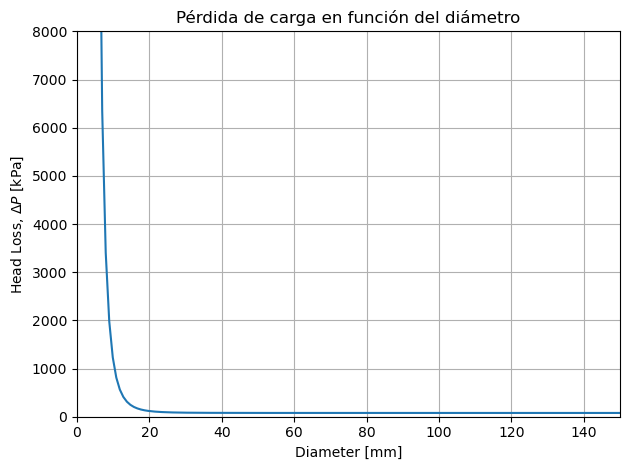

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(D_range * 1000, Delta_P_range)
plt.xlabel("Diameter [mm]")
plt.ylabel(r"Head Loss, $\Delta P$ [kPa]")
plt.title("Pérdida de carga en función del diámetro")
plt.xlim([0, 150])
plt.ylim([0, 8000])
plt.grid(True)
plt.tight_layout()